# 시계열 토픽 모델링(Dynamic Topic Modeling)

### 패키지 설치

In [1]:
# 나눔고딕 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq
!pip install pyLDAvis

In [ ]:
# dtm_binaries 다운로드
!mkdir /dtm_binaries
# !wget -P ./dtm_binaries https://github.com/ByungjunKim/DDMKL/raw/main/dtm_binaries/dtm-linux64
!wget -P ./dtm_binaries https://github.com/magsilva/dtm/raw/master/bin/dtm-linux64

mkdir: cannot create directory ‘/dtm_binaries’: File exists
--2021-01-05 08:38:34--  https://github.com/magsilva/dtm/raw/master/bin/dtm-linux64
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/magsilva/dtm/master/bin/dtm-linux64 [following]
--2021-01-05 08:38:34--  https://raw.githubusercontent.com/magsilva/dtm/master/bin/dtm-linux64
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3601176 (3.4M) [application/octet-stream]
Saving to: ‘./dtm_binaries/dtm-linux64’

dtm-linux64         100%[===================>]   3.43M  --.-KB/s    in 0.1s    

2021-01-05 08:38:35 (35.2 MB/s) - ‘./dtm_binaries/dtm-linux6

In [2]:
!wget https://github.com/ByungjunKim/DDMKL/raw/main/dtm_plot.py

--2021-01-05 10:35:32--  https://github.com/ByungjunKim/DDMKL/raw/main/dtm_plot.py
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/dtm_plot.py [following]
--2021-01-05 10:35:32--  https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/dtm_plot.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7270 (7.1K) [text/plain]
Saving to: ‘dtm_plot.py’

dtm_plot.py         100%[===================>]   7.10K  --.-KB/s    in 0s      

2021-01-05 10:35:32 (80.9 MB/s) - ‘dtm_plot.py’ saved [7270/7270]



In [3]:
import nltk
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm.notebook import tqdm
tqdm.pandas()
import pickle
from sklearn.metrics.pairwise import cosine_similarity

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.callbacks import PerplexityMetric
from gensim.models.wrappers import DtmModel
# https://github.com/magsilva/dtm/tree/master/bin
# path_to_dtm_binary = "./dtm_binaries/dtm-win64.exe" # 윈도우
path_to_dtm_binary = "./dtm_binaries/dtm-linux64"
!chmod -R 777 ./dtm_binaries/dtm-linux64
from gensim.matutils import corpus2csc
from scipy.spatial.distance import cosine
from scipy.stats import linregress

# # Plotting tools
# import seaborn as sns
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
# plt.rc('font', family='NanumBarunGothic')

# Enable logging for gensim - optional
import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# networkx
import networkx as nx

# DTM plot 모듈 로드(dtm_plot.py)
import dtm_plot as dp

NanumBarunGothic


2021-01-05 10:35:38,844 : INFO : generated new fontManager
2021-01-05 10:35:39,049 : INFO : Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
2021-01-05 10:35:39,075 : INFO : Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


### 서지정보 데이터 로드

In [28]:
!wget https://github.com/ByungjunKim/DDMKL/raw/main/phd.pickle

--2021-01-05 11:16:47--  https://github.com/ByungjunKim/DDMKL/raw/main/phd.pickle
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/phd.pickle [following]
--2021-01-05 11:16:48--  https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/phd.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19321960 (18M) [application/octet-stream]
Saving to: ‘phd.pickle’

phd.pickle          100%[===================>]  18.43M  50.7MB/s    in 0.4s    

2021-01-05 11:16:49 (50.7 MB/s) - ‘phd.pickle’ saved [19321960/19321960]



In [29]:
with open('phd.pickle', 'rb') as f:
    phd = pickle.load(f)

In [30]:
phd

,Index,대주제,장르,중주제1,중주제2,대상작가,시대별,서명,기타서명,저자,발행사항,대학,형태사항,일반주기명,학위논문사항,DDC,KDC,발행국,출판년,주제어,소장기관,UCI식별코드,국문 초록 (Abstract),다국어 초록 (Multilingual Abstract),목차,contents,tokens
0,1,작가론,시,시인론,NaN,서정주,통사,"徐廷柱 詩 硏究 = A study on the Poetry of Suh, Jung-Ju",NaN,연은순,"청주 : 청주대학교, 2000",청주대학교,174 p. ; 26 cm.,NaN,학위논문(박사)-- 청주대학교 대학원 : 국어국문학과 국문학전공 2000,NaN,811.6,서울,2000,,"강원대학교 도서관 (242002),국립중앙도서관 (011001),단국대학교 퇴계기념...",NaN,,"This dissertation aims at investigating Suh, J...",목차\r\nI. 서론 = 1\r\n 1. 문제제기 = 1\r\n 2. 연구사 검토 ...,서정주 시 연구 서정주 시 연구 ...,"[서정주, 시, 서정주, 시, 시어, 구사, 비문법성, 시성, 표출, 모순어법, 미..."
1,52,작가론,기타_복합장르,수필_산문_장르론,NaN,"이양하,한흑구",통사,李敭河. 韓黑鷗 隨筆 硏究 : 老莊思想的 側面에서 = (A) study on the...,NaN,박정숙,"서울: 誠信女子大學校, 2000",성신여자대학교,"vi, 168p.; 26cm",NaN,학위논문(박사) -- 성신여자대학교 대학원: 국어국문학과 2000,895.744 21,814.6 4,서울,2000,,"국립중앙도서관 (011001),성신여자대학교 도서관 (211041)",NaN,,NaN,"\n=0,1,3\n논문개요=i,4,4\n목차=v,8,2\nI. 서론=1,10,1\n...",이양하 한흑구 수필 연구 노장사상적 측면에서 ...,"[이양하, 한흑구, 수필, 노장, 사상, 측면, 이양하, 한흑구, 수필, 노장, 사..."
2,51,작가론,비평,비평사,NaN,백철,1930,백철의 휴머니즘 문학 연구 = (A) Study on Humanism of Paek...,NaN,김현정,"대전 : 大田大學校 大學院, 2000",대전대학교,"5, 135p. ; 26cm.",NaN,학위논문(박사)-- 大田大學校 大學院: 國語國文學科 現代文學專攻 2000. 8,NaN,810.906 4,대전,2000,백철 휴머니즘 마르크스주의,"국립중앙도서관 (011001),대전대학교 도서관 (225002),한국교육학술정보원 ...",NaN,,The purpose of this dissertation is to determi...,Ⅰ. 서론 = 1\r\n 1. 연구목적 = 1\r\n 2. 연구사 검토와 문제제...,백철의 휴머니즘 문학 연구 백철의 휴머니즘 문학 연구 ...,"[백철, 휴머니즘, 백철, 휴머니즘, 백철, 휴머니즘, 형성, 배경, 천도, 교사,..."
3,50,작가론,시,시인론,NaN,김소월,1920,金素月 詩에 있어서 '場所愛'의 現象學的 硏究 = (A) Phenomenologic...,NaN,최만종,"서울 : 西江大學校 大學院, 2000",서강대학교,"xi, 153p. ; 26cm",참고문헌: p. 146-153,학위논문(박사)-- 서강대학교 대학원: 국어국문학과 2000,NaN,811.6 4,서울,2000,김소월 시 장소애 현상학,"국립중앙도서관 (011001),서강대학교 도서관 (211029),한국교육학술정보원...",NaN,,NaN,목차 = ⅰ\r\nABSTRACT = ⅵ\r\n국문요약 = ⅷ\r\nⅠ. 序論 = ...,김소월 시에 있어서 장소애 의 현상학적 연구 ...,"[김소월, 시, 장소애, 현상학, 김소월, 시, 장소애, 현상학, 국문, 방법론, ..."
4,49,주제론,소설,소설주제론,NaN,NaN,1950,한국 전후소설의 인물 연구 = (A) Study on Character of Kor...,NaN,이국환,"부산 : 東亞大學校 大學院, 2000",동아대학교,"v, 162p. ; 26cm",참고문헌: p. 151-158,학위논문(박사)-- 동아대학교 대학원: 국어국문학과 2000. 8,NaN,813.6 4,부산,2000,전후소설 통제 인물 사상 환경지향 자기지향 풍자소설 전쟁,"국립중앙도서관 (011001),동아대학교 도서관 (221008),한국교육학술정보원 ...",NaN,본고는 사회심리학의 중요한 개념인 통제(control)의 개념을 통해 작중 인물의 ...,This abstract is studied about the postwar nov...,목차 = ⅳ\r\nⅠ. 서론 = 1\r\n 1. 연구 목적 = 1\r\n 2. 연구...,한국 전후소설의 인물 연구 한국 전후소설의 인물 연...,"[전후, 소설, 인물, 전후, 소설, 인물, 전후소설, 인물, 통제, 전후, 소설,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,1495,작가론,소설,소설작가론,NaN,이청준,해방이후,부끄러움의 탐색과 근대적 주체 비판 연구 : -이청준 소설을 중심으로-,NaN,송은정,"순천 : 순천대학교 대학원, 2019",순천대학교,26 cm,NaN,학위논문(박사)-- 순천대학교 대학원 : 국어국문학과 2019. 2,NaN,NaN,전라남도,2019,,순천대학교 도서관 (246008),I804:46008-000000009483,이청준 소설은 지배적인 담론을 내면화한 근대 주체들이 부끄러움을 느끼는 지점에서 현...,NaN,Ⅰ. 서론 1&#xD;\n 1. 연구 목적 1&#xD;\n 2. 선행연구 검토와...,부끄러움의 탐색과 근대적 주체 비판 연구 이청준 소설을 중심으로 부끄러움의 ...,"[부끄러움, 탐색, 근대, 주체, 비판, 이청준, 소설, 부끄러움, 탐색, 근대, ..."
1524,1496,비교문학,시,비교문학,시인론,"최승호,오리앙하이",해방이후,최승호 시와 오리앙하이 시의 비교 연구,A Comparative Study on Poetries of Seung Ho Ch...,뭉크나랑,"대전: 忠南大學校 大學院, 2019",충남대학교,"ii, 197 p.; 26 cm.","충남대학교 논문은 저작권에 의해 보호받습니다.,지도교수: 이형권,참고문헌 : p. ...",학위논문(박사)-- 忠南大學校 大學院: 국어국문학과 현대문학 전공 2019. 2,895.7 22,NaN,대전,2019,,충남대학교 도서관 (225009),I804:25009-000000079138,본 논문의 목적은 한국시인 최승호와 몽골 시인 오리앙하이의 문학사상과 작품세계를 비...,This paper is a comparative study which compar...,목 차&#xD;\n&#xD;\nⅠ. 서론\t1&#xD;\n 1. 문제 제...,최승호 시와 오리앙하이 시의 비교 연구 최승호 시와 오리앙하이 시의 비교 연구 ...,"[최승호, 시, 오리앙하이, 시, 비교, 최승호, 시, 오리앙하이, 시, 비교, 최..."
1525,1497,문화,비평,문화사 연구(해방 이후),NaN,NaN,통사,문화지리적 이종공간의 서사적 위상학 = A Research on the Narrat...,NaN,정미선,"광주 : 전남대학교 대학원, 2019",전남대학교,201 ; 26 cm,지도교수: 장일구,학위논문(박사)-- 전남대학교 대학원 : 국어국문학과 현대문학(현대소설론) 2019. 2,411,NaN,광주,2019,문화적 경관 체험 공간 인문지리학 문학지리학 서사공간 이종공간 장소의 이종성 시간의...,전남대학교 중앙도서관 (224010),I804:24010-000000060171,이 논문은 ‘문화적 경관(cultural landscape)’에 대한 학제적 연구에...,Space is a key concept in interdisciplinary re...,Ⅰ. 서론 1\r\n 1. 연구 목적 1\r\n 2. 연구사 검토 6\r\n 3. ...,문화지리적 이종공간의 서사적 위상학 문화지리...,"[문화, 지리

In [ ]:
phd['tokens']

0       [서정주, 시, 서정주, 시, 시어, 구사, 비문법성, 시성, 표출, 모순어법, 미...
1       [전후, 소설, 이데올로기, 상관성, 전후, 소설, 이데올로기, 상관성, 전쟁, 이...
2       [근대, 초기, 문학론, 소설화, 근대, 초기, 문학론, 소설화, 차례, 현황, 계...
3       [조지훈, 크리슈나무르티, 선, 선, 동질성, 조지훈, 크리슈나무르티, 선, 선, ...
4       [1950년대, 소설, 여성, 인물, 현실, 수용, 1950, 1950년대, 소설,...
                              ...                        
1523    [서정인, 소설, 변모, 서정인, 소설, 변모, 서술, 순서, 시대, 현실, 충실,...
1524    [여류, 전집, 여성, 젠더, 정치, 여류, 전집, 여성, 젠더, 정치, 1960년...
1525    [어령, 비평, 어령, 비평, 필요성, 시각, 순서, 비평, 사유, 배경, 비평, ...
1526    [이현화, 희곡, 대화, 현실, 인식, 이현화, 희곡, 대화, 현실, 인식, 국문,...
1527    [중국, 일본, 근대, 유미주의, 비교, 김동인, 욱달부, 곡기윤이, 중국, 일본,...
Name: tokens, Length: 1528, dtype: object

In [ ]:
# 토픽 모델링에 활용할 시계열 메타변수(time_slice) 컬럼 만들기
phd['t'] = phd['출판년']-2000
phd['t']

2021-01-05 07:38:51,906 : INFO : NumExpr defaulting to 2 threads.


0        0
1        0
2        0
3        0
4        0
        ..
1523    19
1524    19
1525    19
1526    19
1527    19
Name: t, Length: 1528, dtype: int64

### 모델링

In [ ]:
def prepare_DTM(df,min_count,threshold):
    time_slice = df['tokens'].groupby(df['t']).size()
    data_words = df['tokens'].to_list()
    bigram = gensim.models.Phrases(data_words, min_count=min_count,threshold=threshold)
    bigram_mod =  gensim.models.phrases.Phraser(bigram)
    data_words_bigrams = [bigram_mod[doc] for doc in data_words]
    id2word = corpora.Dictionary(data_words_bigrams)
    corpus = [id2word.doc2bow(text) for text in data_words_bigrams]
    del data_words
    return time_slice, id2word, corpus

In [ ]:
# 최소 100회이상 등장한 단어만 토픽모델링에 활용
time_slice, id2word, corpus = prepare_DTM(phd,100,50)

2021-01-05 07:38:51,935 : INFO : collecting all words and their counts
2021-01-05 07:38:51,936 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2021-01-05 07:38:52,216 : INFO : collected 123945 word types from a corpus of 158072 words (unigram + bigrams) and 1528 sentences
2021-01-05 07:38:52,218 : INFO : using 123945 counts as vocab in Phrases<0 vocab, min_count=100, threshold=50, max_vocab_size=40000000>
2021-01-05 07:38:52,218 : INFO : source_vocab length 123945
2021-01-05 07:38:53,410 : INFO : Phraser built with 0 phrasegrams
2021-01-05 07:38:53,846 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-01-05 07:38:53,984 : INFO : built Dictionary(14545 unique tokens: ['구사', '능청떨기', '대지', '모순어법', '미학']...) from 1528 documents (total 158072 corpus positions)


In [ ]:
DTM_8 = DtmModel(path_to_dtm_binary,
                       corpus=corpus,
                       id2word=id2word,
                       time_slices=time_slice,
                       model='dtm',
                       num_topics=8,
                       rng_seed=2020)

2021-01-05 07:38:54,103 : INFO : serializing temporary corpus to /tmp/e1cb06_train-mult.dat
2021-01-05 07:38:54,104 : INFO : no word id mapping provided; initializing from corpus
2021-01-05 07:38:54,119 : INFO : storing corpus in Blei's LDA-C format into /tmp/e1cb06_train-mult.dat
2021-01-05 07:38:54,175 : INFO : saving vocabulary of 14545 words to /tmp/e1cb06_train-mult.dat.vocab
2021-01-05 07:38:54,195 : INFO : training DTM with args --ntopics=8 --model=dtm  --mode=fit --initialize_lda=true --corpus_prefix=/tmp/e1cb06_train --outname=/tmp/e1cb06_train_out --alpha=0.01 --lda_max_em_iter=10 --lda_sequence_min_iter=6  --lda_sequence_max_iter=20 --top_chain_var=0.005 --rng_seed=2020 
2021-01-05 07:38:54,196 : INFO : Running command ['./dtm_binaries/dtm-linux64', '--ntopics=8', '--model=dtm', '--mode=fit', '--initialize_lda=true', '--corpus_prefix=/tmp/e1cb06_train', '--outname=/tmp/e1cb06_train_out', '--alpha=0.01', '--lda_max_em_iter=10', '--lda_sequence_min_iter=6', '--lda_sequence_max

In [ ]:
# 토픽별 TopN 단어 확인
for i in range(DTM_8.num_topics):
    for t in range(len(DTM_8.time_slices)):
        res = DTM_8.show_topic(i,t,topn=10)
        print('Topic #{}'.format(i), end='\t')
        print(', '.join(w for p, w in res))
    print('\n')

Topic #0	여성, 주체, 욕망, 근대, 근대성, 사랑, 소설, 1960년대, 담론, 몸
Topic #0	여성, 주체, 욕망, 근대, 근대성, 사랑, 소설, 1960년대, 담론, 몸
Topic #0	주체, 여성, 욕망, 근대, 근대성, 사랑, 소설, 1960년대, 담론, 몸
Topic #0	주체, 여성, 근대, 욕망, 근대성, 사랑, 담론, 1960년대, 소설, 몸
Topic #0	주체, 여성, 근대, 욕망, 근대성, 담론, 1960년대, 사랑, 소설, 몸
Topic #0	주체, 여성, 근대, 욕망, 1960년대, 담론, 근대성, 소설, 사랑, 몸
Topic #0	주체, 여성, 근대, 욕망, 1960년대, 담론, 소설, 사랑, 근대성, 몸
Topic #0	주체, 여성, 근대, 욕망, 1960년대, 담론, 소설, 사랑, 몸, 타자
Topic #0	주체, 여성, 근대, 욕망, 1960년대, 소설, 타자, 담론, 사랑, 몸
Topic #0	주체, 여성, 욕망, 근대, 1960년대, 타자, 소설, 사랑, 몸, 담론
Topic #0	주체, 여성, 욕망, 근대, 1960년대, 타자, 소설, 사랑, 몸, 윤리
Topic #0	주체, 여성, 욕망, 근대, 타자, 1960년대, 정치, 사랑, 소설, 윤리
Topic #0	주체, 여성, 욕망, 타자, 근대, 정치, 1960년대, 윤리, 소설, 사랑
Topic #0	주체, 여성, 욕망, 타자, 근대, 정치, 1960년대, 윤리, 소설, 사랑
Topic #0	주체, 여성, 타자, 욕망, 정치, 근대, 1960년대, 소설, 윤리, 몸
Topic #0	주체, 여성, 타자, 정치, 욕망, 근대, 소설, 윤리, 1960년대, 몸
Topic #0	주체, 여성, 타자, 정치, 욕망, 근대, 소설, 윤리, 1960년대, 사랑
Topic #0	주체, 여성, 정치, 타자, 욕망, 소설, 근대, 윤리, 사랑, 공간
Topic #0	주체, 여성, 정치, 타자, 욕망, 소설, 근대, 윤리, 공간, 사랑
Topic #0	주체, 여성, 정치, 욕망, 타

In [ ]:
# 모델 저장
!mkdir ./model
DTM_8.save("./model/DTM_8.model")

2021-01-05 07:47:14,996 : INFO : saving DtmModel object under ./model/DTM_8.model, separately None
2021-01-05 07:47:15,303 : INFO : saved ./model/DTM_8.model


### 모델링 결과 시각화 (논문에 적힌 토픽 번호와 다름)
상허학보 논문에 활용한 모델을 다운받아 시각화

운영체제나 환경에 따라서 조금씩 결과가 상이하게 나오기 때문

In [32]:
!wget -P ./model https://github.com/ByungjunKim/DDMKL/raw/main/model/DTM_8_Paper.model

--2021-01-05 11:19:29--  https://github.com/ByungjunKim/DDMKL/raw/main/model/DTM_8_Paper.model
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/model/DTM_8_Paper.model [following]
--2021-01-05 11:19:30--  https://raw.githubusercontent.com/ByungjunKim/DDMKL/main/model/DTM_8_Paper.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59330676 (57M) [application/octet-stream]
Saving to: ‘./model/DTM_8_Paper.model.1’

DTM_8_Paper.model.1 100%[===================>]  56.58M   157MB/s    in 0.4s    

2021-01-05 11:19:31 (157 MB/s) - ‘./model/DTM_8_Paper.model.1’ saved [59330676/5933067

In [33]:
DTM_8 =  DtmModel.load('./model/DTM_8_Paper.model')

2021-01-05 11:19:32,362 : INFO : loading DtmModel object from ./model/DTM_8_Paper.model
2021-01-05 11:19:32,543 : INFO : loading id2word recursively from ./model/DTM_8_Paper.model.id2word.* with mmap=None
2021-01-05 11:19:32,545 : INFO : loaded ./model/DTM_8_Paper.model


In [ ]:
# 플롯 및 토픽별 TopN단어 엑셀로 저장할 폴더 생성
!mkdir ./plot

#### 용어 설명
*   Variance : 시간의 흐름에 따라 토픽 內 단어들 중 변화량이 가장 단어 내림차순
*   Slope (positvie) : Variance의 방향이 시간이 흐를수록 상승하는 단어 내림차순
*   Slope (negative) : Variance의 방향이 시간이 흐를수록 하락하는 단어 내림차순

#### 토픽 #0 : 연극/영화_대중문화

In [ ]:
dp.topic_summary(DTM_8,0)

Variance
---------
('연극', 5.962555966605603e-05)
('텍스트', 4.54585084242149e-05)
('희곡', 2.264661822322492e-05)
('영화', 2.241707533047621e-05)
('구조', 1.9387537298741434e-05)
('서사', 1.4822435313334277e-05)
('극', 7.31829752121012e-06)
('드라마', 6.317793826007372e-06)
('독자', 2.5799816465915653e-06)
('미학', 2.2735709995616295e-06)
('영상', 2.1159801040797375e-06)
('변화', 1.6817265012232824e-06)
('게임', 9.478155855681061e-07)
('문화', 8.760712035056542e-07)
('차이', 8.690131181579854e-07)
('동아일보', 7.411634055242766e-07)
('놀이', 6.492991627329516e-07)
('인물', 6.333398586888447e-07)
('1980년대', 5.851709859928357e-07)
('매체', 4.4611239942586417e-07)

Slope (positive)
----------
('드라마', 0.00040267035922399006)
('독자', 0.0002607688971269449)
('영화', 0.0002499016855426639)
('문화', 0.00015960117747335716)
('차이', 0.0001559702238200742)
('동아일보', 0.00014072323105847917)
('인물', 0.00013362311053430068)
('1980년대', 0.00013016803651216065)
('인지', 9.402943457093163e-05)
('역사드라마', 8.116950169314382e-05)
('배경', 8.073450783624338e

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f761891bf60>)

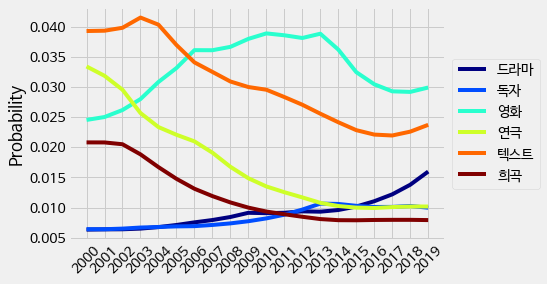

In [ ]:
dp.plot_terms(DTM_8,0,['드라마','독자','영화','연극','텍스트','희곡'],range(2000,2020),
            name="./plot/topic0_연극영화_대중문화")

#### 토픽 #1 : 비평과 시론 기타

In [ ]:
dp.topic_summary(DTM_8,1)

Variance
---------
('수용', 1.4379597548697613e-05)
('중국', 1.2945097543718397e-05)
('조선', 5.621218373612539e-06)
('비교', 5.046919326401694e-06)
('근대', 3.2488717137652177e-06)
('전통', 2.9495756244035292e-06)
('문예', 2.4836608238395248e-06)
('민족', 1.8919306799991965e-06)
('북한', 1.6574323894496742e-06)
('시', 9.274184881575475e-07)
('순수', 7.492238560149551e-07)
('영향', 6.489869198079169e-07)
('해방기', 6.186859780685494e-07)
('비평', 6.100434963441495e-07)
('리얼리즘', 5.499441679079173e-07)
('운동', 5.085062325041871e-07)
('활동', 3.746929628115438e-07)
('작품', 3.3838298624017833e-07)
('창작', 3.2209337828813204e-07)
('문화', 3.0839757247652916e-07)

Slope (positive)
----------
('중국', 0.0005652971291970993)
('수용', 0.0005145576119693447)
('조선', 0.00036864517950416963)
('비교', 0.0003316581007097192)
('근대', 0.00030572853079420884)
('문예', 0.0002719095638698978)
('순수', 0.00014425642435694492)
('비평', 0.00012626884099609123)
('해방기', 0.00012582378710214893)
('활동', 0.00010412067996155803)
('문화', 9.317119053468893e-05)
('조

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7617afcf60>)

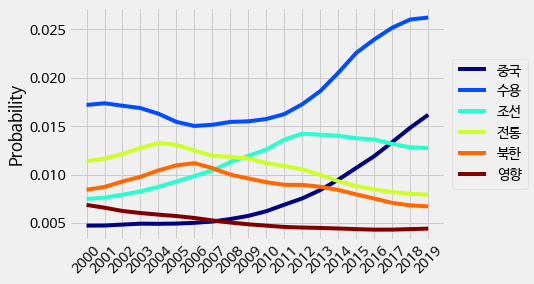

In [ ]:
dp.plot_terms(DTM_8,1,['중국','수용','조선','전통','북한','영향'],range(2000,2020),
            name="./plot/topic1_비평과 시론")

#### 토픽 #2 : 시주제론

In [ ]:
dp.topic_summary(DTM_8,2)

Variance
---------
('시', 1.5719135498954237e-05)
('주체', 9.649491073127638e-06)
('언어', 4.274708945546679e-06)
('현실', 3.5710278589172425e-06)
('의식', 2.7896650133296413e-06)
('죽음', 1.9375055796103072e-06)
('생명', 1.4822584306789149e-06)
('인식', 9.402140469699673e-07)
('미학', 8.653333771651783e-07)
('김수영', 7.243718965724656e-07)
('지향', 6.382709648515498e-07)
('상상력', 5.797722372894363e-07)
('생태', 4.56541952829905e-07)
('현대시', 3.924221294852352e-07)
('의미', 3.503831533791725e-07)
('실천', 3.426575269477786e-07)
('현대', 3.3654121192700426e-07)
('사상', 3.1856624387990307e-07)
('비판', 3.169658385040614e-07)
('세계', 2.7007261012124025e-07)

Slope (positive)
----------
('주체', 0.0005090716484582942)
('언어', 0.0003366766954005371)
('미학', 0.0001285161902634611)
('상상력', 0.00010699157537930778)
('실천', 9.94286987233277e-05)
('죽음', 9.632285835586474e-05)
('세계', 8.149407626440568e-05)
('시인', 7.440743057346831e-05)
('이상', 7.061897803289985e-05)
('알레고리', 6.536712319161885e-05)
('사회', 6.36078048391987e-05)
('민중', 5.89

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7617afca20>)

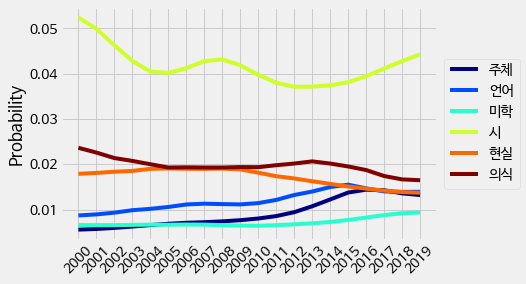

In [ ]:
dp.plot_terms(DTM_8,2,['주체','언어','미학','시','현실','의식'],range(2000,2020),
            name="./plot/topic2_시주제론")

#### 토픽 #3 : 여성문학_젠더

In [ ]:
dp.topic_summary(DTM_8,3)

Variance
---------
('여성', 7.245844765071352e-05)
('근대', 7.177283129595905e-05)
('공간', 6.649781354500842e-05)
('근대성', 5.594747707087875e-05)
('모더니즘', 5.7543752512981425e-06)
('1930년대', 4.7275320217611295e-06)
('욕망', 4.613347301398849e-06)
('육체', 2.6412903432828487e-06)
('도시', 1.8628272441902804e-06)
('감각', 1.6131466906783315e-06)
('주체', 1.569129636250779e-06)
('일상', 1.3862898370817163e-06)
('몸', 1.2126447556352102e-06)
('젠더', 1.147785959036538e-06)
('신체', 9.537976915444527e-07)
('글쓰기', 7.690832015653186e-07)
('여행', 6.416406829043037e-07)
('김승옥', 5.550920687127221e-07)
('시각', 4.629165420165614e-07)
('자아', 4.049995429219621e-07)

Slope (positive)
----------
('공간', 0.0013601522404736138)
('감각', 0.0001991717687553996)
('젠더', 0.00017330037922775788)
('글쓰기', 0.0001421048599504987)
('여행', 0.00013683629329181864)
('시각', 0.00011721632784836525)
('체험', 0.00010431227977189201)
('서사', 9.210255145585051e-05)
('1970년대', 8.326684541729957e-05)
('경성', 8.144016619377561e-05)
('전집', 7.447310679798268e-05

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f76177c5fd0>)

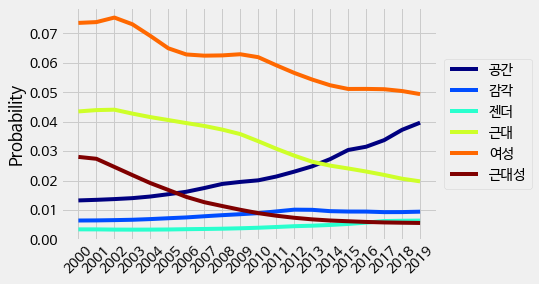

In [ ]:
dp.plot_terms(DTM_8,3,['공간','감각','젠더','근대','여성','근대성'],range(2000,2020),
            name="./plot/topic3_여성문학_젠더")

#### 토픽 #4 : 시양식론

In [ ]:
dp.topic_summary(DTM_8,4)

Variance
---------
('공간', 3.9489769165130534e-05)
('이미지', 1.902932652875953e-05)
('기억', 1.3003653874787339e-05)
('의식', 1.2252144487723824e-05)
('시간', 9.19654144777022e-06)
('구조', 8.591019157513391e-06)
('서술', 5.467087915927197e-06)
('세계', 3.4581359385858826e-06)
('자아', 2.2608101113237533e-06)
('주체', 1.6969409336777002e-06)
('인식', 1.4945626488018254e-06)
('화자', 1.1073550406173173e-06)
('은유', 1.0456362484391472e-06)
('시점', 7.781615483265447e-07)
('시', 7.542628226164498e-07)
('서정', 4.374505948473883e-07)
('고향', 3.8354931048064954e-07)
('상상력', 3.2816072945357957e-07)
('정체성', 3.069916433201066e-07)
('반복', 3.014875446295482e-07)

Slope (positive)
----------
('이미지', 0.0006915366094772014)
('기억', 0.000602152173724992)
('주체', 0.00021762617156321828)
('인식', 0.00020081378223737645)
('은유', 0.00015987399034384474)
('정체성', 9.488772898599515e-05)
('고향', 8.566917557365087e-05)
('공동체', 7.850649949596192e-05)
('불안', 7.37545039732322e-05)
('시', 6.970908754459631e-05)
('실존', 6.567635708211142e-05)
('치유', 

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7618a78e80>)

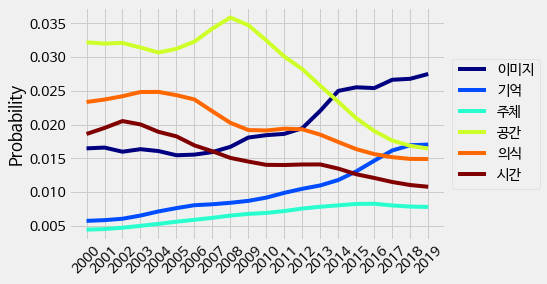

In [ ]:
dp.plot_terms(DTM_8,4,['이미지','기억','주체','공간','의식','시간'],range(2000,2020),
            name="./plot/topic4_시양식론")

#### 토픽 #5 : 소설주제론과 문화론적 연구

In [ ]:
dp.topic_summary(DTM_8,5)

Variance
---------
('근대', 4.178259893004495e-05)
('소설', 3.9312246892792444e-05)
('형성', 1.7879054717814226e-05)
('교육', 4.733996122502477e-06)
('고백', 4.651569317060758e-06)
('변화', 2.88845550999061e-06)
('소년', 2.7104868724584553e-06)
('개화기', 2.3422134409352534e-06)
('청소년', 2.3373021145271284e-06)
('독자', 2.3191410889901666e-06)
('아동', 2.268756963746265e-06)
('잡지', 2.244085862884025e-06)
('수용', 1.9927411690096275e-06)
('문화', 1.686981380666382e-06)
('서사', 1.404091589793627e-06)
('양식', 1.3410349529072279e-06)
('신소설', 1.325646641538984e-06)
('문체', 1.2600432852753473e-06)
('1920년대', 7.654322556875057e-07)
('번역', 7.466429479291977e-07)

Slope (positive)
----------
('교육', 0.000290745244455635)
('변화', 0.0002857294662751328)
('잡지', 0.00025416644757044507)
('청소년', 0.0002540546417177829)
('소년', 0.00024664309629614126)
('아동', 0.00023727083793997374)
('문화', 0.00021272579709989944)
('독자', 0.00016849899545611668)
('매체', 0.00012939410391270094)
('연재', 0.00012417921356931632)
('번역', 0.0001221167302334458)


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f76179f2be0>)

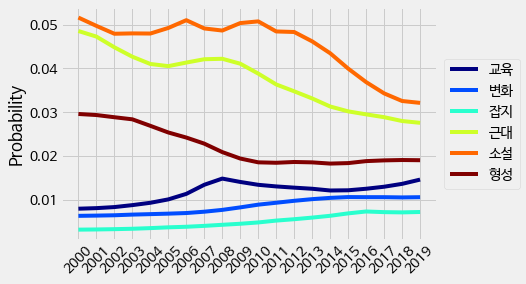

In [ ]:
dp.plot_terms(DTM_8,5,['교육','변화','잡지','근대','소설','형성'],range(2000,2020),
            name="./plot/topic5_소설주제론과 문화론적 연구")

#### 토픽 #6 : 소설양식론

In [ ]:
dp.topic_summary(DTM_8,6)

Variance
---------
('소설', 4.022164003730975e-05)
('구조', 8.815815593242012e-06)
('의식', 7.950198861879065e-06)
('서사', 7.063948386905095e-06)
('인물', 3.648778097410363e-06)
('역사', 2.4197020427267097e-06)
('작가', 2.364143320573161e-06)
('인식', 1.7600895113871716e-06)
('전쟁', 1.7578908215440933e-06)
('형상화', 1.2817638199838973e-06)
('현실', 1.2235973047905591e-06)
('욕망', 1.2123144754707567e-06)
('재현', 1.1415465334943093e-06)
('서술', 9.757975801870312e-07)
('의미', 7.273136398774797e-07)
('비판', 6.676983206364876e-07)
('대응', 4.195938616395814e-07)
('현대', 3.801375599616565e-07)
('시대', 3.468082366338829e-07)
('1960년대', 3.20137583286417e-07)

Slope (positive)
----------
('의식', 0.00048171659350342927)
('서사', 0.00042907984492954236)
('작가', 0.0002625226865828318)
('전쟁', 0.00022179993912808705)
('인식', 0.00020664322677479632)
('형상화', 0.00019289241483696427)
('욕망', 0.0001841299669608173)
('재현', 0.0001830672782498126)
('역사', 0.00018154298761897044)
('비판', 0.0001398032976861283)
('의미', 0.00012930082625582927)
('대

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7617789198>)

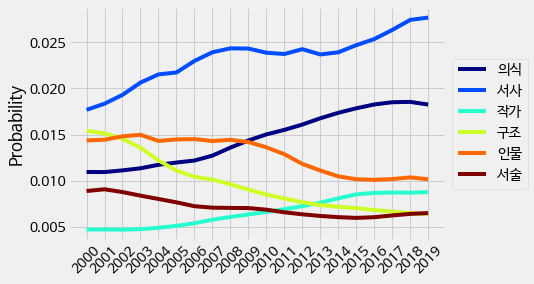

In [ ]:
dp.plot_terms(DTM_8,6,['의식','서사','작가','구조','인물','서술'],range(2000,2020),
            name="./plot/topic6_소설양식론")

#### 토픽 #7 : 소설주제론과 기타

In [ ]:
dp.topic_summary(DTM_8,7)

Variance
---------
('담론', 9.027505041744699e-05)
('근대', 2.7022790556072828e-05)
('정치', 1.6673621927873463e-05)
('욕망', 1.278118488013185e-05)
('주체', 1.1250466568882134e-05)
('사랑', 8.362084411873225e-06)
('공동체', 3.937514577785512e-06)
('윤리', 2.13095697788582e-06)
('민족', 1.7457825520481031e-06)
('연애', 1.5657203765629122e-06)
('민중', 1.0971242667578675e-06)
('타자', 9.423251128122938e-07)
('형성', 8.327594235552048e-07)
('이데올로기', 7.866231368704837e-07)
('개인', 7.563454050838625e-07)
('식민지', 6.612718902796537e-07)
('문화', 5.590718762004687e-07)
('국가', 4.622280085855855e-07)
('폭력', 4.6090887459959303e-07)
('계몽', 4.030560327217838e-07)

Slope (positive)
----------
('정치', 0.0006801869551086344)
('공동체', 0.00032788625686662584)
('윤리', 0.0002308258716176471)
('민중', 0.00017961329095002987)
('타자', 0.00014971822088530724)
('폭력', 0.00011220063572705814)
('국가', 0.00010427564128766208)
('전유', 0.00010415584769127173)
('혁명', 0.00010158842861523764)
('연대', 8.874987025859175e-05)
('사회', 8.707808402534305e-05)
('재

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f761791ad68>)

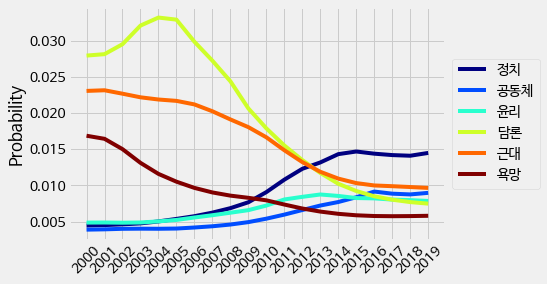

In [ ]:
dp.plot_terms(DTM_8,7,['정치','공동체','윤리','담론','근대','욕망'],range(2000,2020),
            name="./plot/topic7_소설주제론과 기타")

#### 시간에 따른 토픽 비율변화

In [35]:
DTM_8.time_slices.values

array([ 71,  71,  99, 103,  70,  91,  82,  65,  82,  79,  84,  84,  84,
        75,  84,  65,  65,  62,  55,  57])

In [7]:
DTM_8_topic_proportion = dp.topic_proportion(DTM_8,20,DTM_8.time_slices.values)
DTM_8_topic_proportion = DTM_8_topic_proportion*100

2021-01-05 10:36:37,846 : INFO : NumExpr defaulting to 2 threads.


In [8]:
DTM_8_topic_proportion # 퍼센트

,0,1,2,3,4,5,6,7
0,3.201020,17.677137,20.747887,6.412425,12.116200,7.325528,23.373792,9.146010
1,8.471188,14.881247,15.937677,7.621773,14.151561,6.190192,26.134296,6.612065
2,8.143265,13.396545,17.592907,7.353647,16.934086,6.919120,22.715299,6.945129
3,7.364622,10.102927,18.536140,7.278397,16.076229,8.649192,23.310551,8.681942
4,8.395812,10.806142,16.199055,9.355016,17.283057,7.200036,22.974608,7.786276
5,8.409743,13.935094,17.549771,6.676850,14.430202,7.821485,23.829049,7.347806
6,8.771056,12.102018,18.161565,8.110065,17.545834,6.731941,21.736228,6.841293
7,8.129873,14.526414,17.512522,7.770534,15.081789,6.810395,23.299872,6.868601
8,7.507702,13.641948,16.261840,8.219974,12.895296,8.723705,25.627812,7.121723
9,8.585301,14.295062,18.563035,6.997537,15.799713,6.590745,22.038761,7.129847


In [9]:
# index를 연도로 전환 (2000~2019)
DTM_8_topic_proportion.index = range(2000,2020,1)

In [10]:
DTM_8_topic_proportion.columns=['연극/영화_대중문화','비평과 시론_기타','시주제론','여성문학/젠더','시양식론','소설주제론과 문화론적 연구','소설양식론','소설주제론과 기타']
DTM_8_topic_proportion

,연극/영화_대중문화,비평과 시론_기타,시주제론,여성문학/젠더,시양식론,소설주제론과 문화론적 연구,소설양식론,소설주제론과 기타
2000,3.201020,17.677137,20.747887,6.412425,12.116200,7.325528,23.373792,9.146010
2001,8.471188,14.881247,15.937677,7.621773,14.151561,6.190192,26.134296,6.612065
2002,8.143265,13.396545,17.592907,7.353647,16.934086,6.919120,22.715299,6.945129
2003,7.364622,10.102927,18.536140,7.278397,16.076229,8.649192,23.310551,8.681942
2004,8.395812,10.806142,16.199055,9.355016,17.283057,7.200036,22.974608,7.786276
2005,8.409743,13.935094,17.549771,6.676850,14.430202,7.821485,23.829049,7.347806
2006,8.771056,12.102018,18.161565,8.110065,17.545834,6.731941,21.736228,6.841293
2007,8.129873,14.526414,17.512522,7.770534,15.081789,6.810395,23.299872,6.868601
2008,7.507702,13.641948,16.261840,8.219974,12.895296,8.723705,25.627812,7.121723
2009,8.585301,14.295062,18.563035,6.997537,15.799713,6.590745,22.038761,7.129847


In [11]:
# 연도별 토픽 비율 평균
DTM_8_topic_proportion.mean().sort_values(ascending=False)

소설양식론             23.884388
시주제론              17.477547
시양식론              15.007263
비평과 시론_기타         14.085968
연극/영화_대중문화         7.682721
여성문학/젠더            7.595909
소설주제론과 문화론적 연구     7.277903
소설주제론과 기타          6.988302
dtype: float64

In [12]:
# 비율 큰 순서로 정렬
DTM_8_topic_proportion = DTM_8_topic_proportion.reindex(DTM_8_topic_proportion.mean().sort_values(ascending=False).index,axis=1)
DTM_8_topic_proportion

,소설양식론,시주제론,시양식론,비평과 시론_기타,연극/영화_대중문화,여성문학/젠더,소설주제론과 문화론적 연구,소설주제론과 기타
2000,23.373792,20.747887,12.116200,17.677137,3.201020,6.412425,7.325528,9.146010
2001,26.134296,15.937677,14.151561,14.881247,8.471188,7.621773,6.190192,6.612065
2002,22.715299,17.592907,16.934086,13.396545,8.143265,7.353647,6.919120,6.945129
2003,23.310551,18.536140,16.076229,10.102927,7.364622,7.278397,8.649192,8.681942
2004,22.974608,16.199055,17.283057,10.806142,8.395812,9.355016,7.200036,7.786276
2005,23.829049,17.549771,14.430202,13.935094,8.409743,6.676850,7.821485,7.347806
2006,21.736228,18.161565,17.545834,12.102018,8.771056,8.110065,6.731941,6.841293
2007,23.299872,17.512522,15.081789,14.526414,8.129873,7.770534,6.810395,6.868601
2008,25.627812,16.261840,12.895296,13.641948,7.507702,8.219974,8.723705,7.121723
2009,22.038761,18.563035,15.799713,14.295062,8.585301,6.997537,6.590745,7.129847


In [13]:
# 주제별로 정렬 (소설, 시, 기타 순)
thema_order = ['소설양식론','소설주제론과 문화론적 연구','소설주제론과 기타','시주제론','시양식론','비평과 시론_기타','연극/영화_대중문화','여성문학/젠더']
DTM_8_topic_proportion[thema_order]

,소설양식론,소설주제론과 문화론적 연구,소설주제론과 기타,시주제론,시양식론,비평과 시론_기타,연극/영화_대중문화,여성문학/젠더
2000,23.373792,7.325528,9.146010,20.747887,12.116200,17.677137,3.201020,6.412425
2001,26.134296,6.190192,6.612065,15.937677,14.151561,14.881247,8.471188,7.621773
2002,22.715299,6.919120,6.945129,17.592907,16.934086,13.396545,8.143265,7.353647
2003,23.310551,8.649192,8.681942,18.536140,16.076229,10.102927,7.364622,7.278397
2004,22.974608,7.200036,7.786276,16.199055,17.283057,10.806142,8.395812,9.355016
2005,23.829049,7.821485,7.347806,17.549771,14.430202,13.935094,8.409743,6.676850
2006,21.736228,6.731941,6.841293,18.161565,17.545834,12.102018,8.771056,8.110065
2007,23.299872,6.810395,6.868601,17.512522,15.081789,14.526414,8.129873,7.770534
2008,25.627812,8.723705,7.121723,16.261840,12.895296,13.641948,7.507702,8.219974
2009,22.038761,6.590745,7.129847,18.563035,15.799713,14.295062,8.585301,6.997537


In [44]:
DTM_8_topic_proportion[thema_order].to_excel('./plot/topic_prop.xlsx')

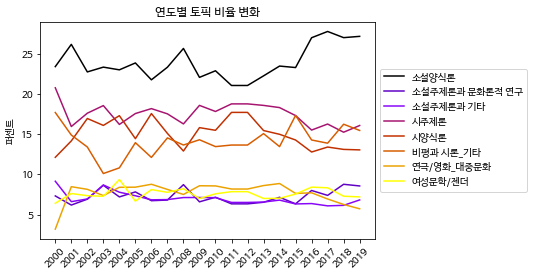

In [17]:
import matplotlib.pyplot as plt
f = plt.figure()
plt.title('연도별 토픽 비율 변화', color='black')
DTM_8_topic_proportion[thema_order].plot(ax=f.gca(),colormap='gnuplot')
plt.xticks(np.array(range(2000,2020)),rotation=45)
ax=f.gca()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('퍼센트')
plt.show()

#### 토픽 - 토픽 네트워크

In [34]:
# 전체 Topic - Topic Network
pd.DataFrame(cosine_similarity(DTM_8.gamma_.T))
t_t_net = pd.DataFrame(cosine_similarity(DTM_8.gamma_.T))

In [35]:
t_t_net.columns = [f'topic{num}' for num in range(0,8)]
t_t_net.index = [f'topic{num}' for num in range(0,8)]
t_t_net

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
topic0,1.000000,0.107623,0.071600,0.092041,0.116249,0.122709,0.154275,0.095872
topic1,0.107623,1.000000,0.154493,0.071456,0.136224,0.114019,0.162244,0.144608
topic2,0.071600,0.154493,1.000000,0.165893,0.267120,0.046396,0.139721,0.162735
topic3,0.092041,0.071456,0.165893,1.000000,0.152928,0.125271,0.226560,0.225316
topic4,0.116249,0.136224,0.267120,0.152928,1.000000,0.051417,0.208191,0.115366
topic5,0.122709,0.114019,0.046396,0.125271,0.051417,1.000000,0.138519,0.172347
topic6,0.154275,0.162244,0.139721,0.226560,0.208191,0.138519,1.000000,0.253837
topic7,0.095872,0.144608,0.162735,0.225316,0.115366,0.172347,0.253837,1.000000


In [36]:
t_t_net.to_csv('./plot/topic_topic_network.csv')

In [37]:
phd[phd['출판년']<2010].index # index 812까지가 2009년

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            803, 804, 805, 806, 807, 808, 809, 810, 811, 812],
           dtype='int64', length=813)

In [40]:
# 2000년대 Topic-Topic Network
t_t_net_2000 = pd.DataFrame(cosine_similarity(DTM_8.gamma_[:813].T))

In [41]:
t_t_net_2000.columns = [f'topic{num}' for num in range(0,8)]
t_t_net_2000.index = [f'topic{num}' for num in range(0,8)]
t_t_net_2000

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
topic0,1.000000,0.103014,0.078124,0.083765,0.135461,0.140761,0.149500,0.074529
topic1,0.103014,1.000000,0.154271,0.048196,0.122578,0.079291,0.176350,0.134177
topic2,0.078124,0.154271,1.000000,0.163047,0.266944,0.044890,0.143018,0.141908
topic3,0.083765,0.048196,0.163047,1.000000,0.140823,0.129187,0.231039,0.197715
topic4,0.135461,0.122578,0.266944,0.140823,1.000000,0.051866,0.207492,0.087045
topic5,0.140761,0.079291,0.044890,0.129187,0.051866,1.000000,0.160574,0.153131
topic6,0.149500,0.176350,0.143018,0.231039,0.207492,0.160574,1.000000,0.250135
topic7,0.074529,0.134177,0.141908,0.197715,0.087045,0.153131,0.250135,1.000000


In [42]:
t_t_net_2000.to_csv('./plot/topic_topic_network_2000.csv')

In [43]:
# 2010년대 Topic-Topic Network
t_t_net_2010 = pd.DataFrame(cosine_similarity(DTM_8.gamma_[813:].T))

In [44]:
t_t_net_2010.columns = [f'topic{num}' for num in range(0,8)]
t_t_net_2010.index = [f'topic{num}' for num in range(0,8)]
t_t_net_2010

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
topic0,1.000000,0.118195,0.064570,0.100143,0.094442,0.102546,0.161900,0.115776
topic1,0.118195,1.000000,0.159678,0.106453,0.161050,0.171529,0.138125,0.167900
topic2,0.064570,0.159678,1.000000,0.169381,0.267581,0.048135,0.136584,0.183105
topic3,0.100143,0.106453,0.169381,1.000000,0.166704,0.122371,0.227223,0.247538
topic4,0.094442,0.161050,0.267581,0.166704,1.000000,0.050878,0.209899,0.144622
topic5,0.102546,0.171529,0.048135,0.122371,0.050878,1.000000,0.109333,0.192723
topic6,0.161900,0.138125,0.136584,0.227223,0.209899,0.109333,1.000000,0.265766
topic7,0.115776,0.167900,0.183105,0.247538,0.144622,0.192723,0.265766,1.000000


In [45]:
t_t_net_2010.to_csv('./plot/topic_topic_network_2010.csv')